<p align="center" text-align="center">
  <img width='1000' height='550' src="https://drive.google.com/uc?id=1_ivV8LKEPdqGf6mkKtmXlFYADy6elvfm">
</p>



# Setting Up

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
time: 28.6 s


In [0]:
%cd drive/My\ Drive/KagglePUBG

/content/drive/My Drive/KagglePUBG
time: 15.2 ms


In [0]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

time: 21.5 ms


In [0]:
!pip install ipython-autotime

time: 4.21 s


# Load

In [0]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.48 ms


In [0]:
train=pd.read_csv("train_V2.csv.zip")
train=reduce_mem_usage(train)

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 288.39 MB
Decreased by 70.7%
time: 26.6 s


# Feature Engineering

In [0]:
def pre_process(train,isTraining=True):
  if isTraining:
    train.dropna(inplace=True)
    train.reset_index(inplace=True,drop=True)
  train=create_new_features(train)
  if isTraining:
    train=reduce_mem_usage(remove_anomalies(train))
    train=reduce_mem_usage(remove_outlier(train))
    
  train=reduce_mem_usage(categorical_variable_encoding(train))

  train=reduce_mem_usage(normalize(train))
  droppers = ['assists','boosts', 'damageDealt','DBNOs','headshotKills','heals',
            'killPoints','matchDuration','rankPoints','revives','roadKills',
            'swimDistance','rideDistance','vehicleDestroys','walkDistance','weaponsAcquired',
            'winPoints','killPlace','kills', 'memberCount']
  
  train=reduce_mem_usage(train.drop(columns=droppers))
  train=reduce_mem_usage(train.drop(columns=['Id','groupId','matchId']))
  return train

time: 7.51 ms


In [0]:
def normalize(train):
  ############# Normalization based on match (rank as percent)
  match=train.groupby('matchId')
  # Weapons acquired / Total Weapons in the match
  train['weaponsAcquiredPerc'] = match['weaponsAcquired'].rank(pct=True).values
  # Kills / Total Kills in the match
  train['killPerc'] = match['kills'].rank(pct=True).values
  # Percentage of kill place in the match that the player gets
  train['killPlacePerc'] = match['killPlace'].rank(pct=True).values
  # Walk Distance / Total Walk Distance in the match
  train['walkDistancePerc'] = match['walkDistance'].rank(pct=True).values
  train['walkPercPerkillsPerc'] = train['walkDistancePerc'] / train['killPerc']


  # Percentage of total damagedealt in the match that the player gets
  train['damageDealt'] = match['damageDealt'].rank(pct=True).values

  # Percentage of total knocks in the match that the player gets
  train['DBNOsPerc'] = match['DBNOs'].rank(pct=True).values
  # Percent of total kills by the team in the match
  train['totalKillsByTeamPerc'] = train.groupby('groupId')['kills'].transform('sum') / match['kills'].transform('sum')

  # Ride Distance / Total Ride Distance in the match
  train['rideDistancePerc'] = match['rideDistance'].rank(pct=True).values
  # Swim Distance / Total Swim Distance in the match
  train['swimDistancePerc'] = match['swimDistance'].rank(pct=True).values
  # players total Distance / Total  Distance in the match
  # train['totalDistancePerc'] =match['totalDistance'].rank(pct=True).values

 
  ############# Normalization based on playersJoined
  train['matchDurationNorm'] = train['matchDuration']*((100-train['playersJoined'])/100 + 1)

  ############# Filling
  train[train == np.Inf] = np.NaN
  train[train == np.NINF] = np.NaN
  train.fillna(0, inplace=True)

  return train

time: 25.1 ms


In [0]:
def create_new_features(train): 
  match=train.groupby('matchId') 
  # create new feature players Joined
  train['playersJoined'] = match['matchId'].transform('count')
  # create new feature member count
  train['memberCount'] = train.groupby('groupId')['groupId'].transform('count')
  # create new feature totalDistance
  train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']
  # Create new feature healsandboosts
  train['healsandboosts'] = train['heals'] + train['boosts']
  # Percent of total heals by the team in the match
  train['totalHealsBoostsPerc'] = train.groupby('groupId')['healsandboosts'].transform('sum') / train.groupby('matchId')['healsandboosts'].transform('sum')
  # Create new feature teamWork
  train['teamWork'] = train['assists'] + train['revives']
  # Create headshot_rate feature
  train['headshot_rate'] =  train['kills'] /train['headshotKills']
  train['headshotKills_over_kills'] = train['headshotKills'] / train['kills']
  train['killStreakrate'] = train['killStreaks']/train['kills']
  train['killsOverWalkDistance'] = train['kills'] / train['walkDistance']
  train['killPlaceOverMaxPlace'] = train['killPlace'] / train['maxPlace']
  train['distance_over_weapons'] = train['totalDistance'] / train['weaponsAcquired']
  train['walkDistance_over_heals'] = train['walkDistance'] / train['heals']
  train['walkDistance_over_kills'] = train['walkDistance'] / train['kills']
  train['killsPerWalkDistance'] = train['kills'] / train['walkDistance']
  train["skill"] = train["headshotKills"] + train["roadKills"]
  train[train == np.Inf] = np.NaN
  train[train == np.NINF] = np.NaN
  train.fillna(0, inplace=True)
  #create new feature killandrankpoints
  train.loc[(train['rankPoints']==-1), 'rankPoints'] = 0
  train.loc[(train['winPoints']==-1), 'winPoints'] = 0
  train['EloRankpoints'] = train['rankPoints']+train['killPoints']+train['winPoints']
  train['EloRankpoints'] =MinMaxScaler().fit_transform(train['EloRankpoints'].to_numpy().reshape(-1,1))
  return train


time: 22.6 ms


In [0]:
def remove_anomalies(train):
  # Remove kills Without Moving
  train.drop(train[((train['kills'] > 0) & (train['totalDistance'] == 0))].index, inplace=True)
  # Remove road kills anomalies
  train.drop(train[train['roadKills'] > 10].index, inplace=True)
  # Remove headshot rate anomalies
  train.drop(train[(train['headshot_rate'] == 1) & (train['kills'] > 10)].index, inplace=True)
  # Remove heals and boosts anomalies
  train.drop(train[train['healsandboosts']>30].index, inplace=True)
  # Remove team kills which are more than 3
  train.drop(train[train['teamKills'] >3].index, inplace=True)
  # Remove Zombies
  train.drop(train.query('walkDistance == 0 & kills == 0 & weaponsAcquired == 0 & \'solo\' in matchType').index,inplace=True)
  train.drop(train[train['memberCount'] > 4].index, inplace=True)
  return train


time: 11.6 ms


In [0]:
def remove_outlier(train):
  # Remove kills more than 30 (95 players)
  train.drop(train[train['kills'] > 30].index, inplace=True)

  # Remove kill distance more than 1km 
  train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

  # Remove enemy knock out more than 20
  train.drop(train[train['DBNOs'] >20].index, inplace=True)

  # Remove kill streak more than 10
  train.drop(train[train['killStreaks'] >10].index, inplace=True)

  # Remove assists to kill more than 10
  train.drop(train[train['assists'] >10].index, inplace=True)

  # Remove distance based outliers 
  train.drop(train[train['walkDistance'] >10000.0].index, inplace=True)
  train.drop(train[train['rideDistance'] >15000.0].index, inplace=True)
  train.drop(train[train['swimDistance'] >1000.0].index, inplace=True)

  # Remove players that acquired more than 80 weapons in a match
  train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)

  # Remove vehicle destroys more than 2
  train.drop(train[train['vehicleDestroys'] >2].index, inplace=True)

  # Remove revives more than 5
  train.drop(train[train['revives'] >5].index, inplace=True)

  return train

time: 14.3 ms


In [0]:
def categorical_variable_encoding(train):
  """ A categorical aggerriagtion """
  mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
  train['matchType'] = train['matchType'].apply(mapper)
  train = pd.concat([train, pd.get_dummies(train['matchType'])], axis=1)
  train.drop(['matchType'], axis=1, inplace=True)
  return train

time: 10.1 ms


In [0]:
train=pre_process(train)

Memory usage of dataframe is 554.85 MB
Memory usage after optimization is: 371.08 MB
Decreased by 33.1%
Memory usage of dataframe is 370.93 MB
Memory usage after optimization is: 367.40 MB
Decreased by 1.0%
Memory usage of dataframe is 349.73 MB
Memory usage after optimization is: 360.33 MB
Decreased by -3.0%
Memory usage of dataframe is 664.14 MB
Memory usage after optimization is: 430.98 MB
Decreased by 35.1%
Memory usage of dataframe is 332.07 MB
Memory usage after optimization is: 332.07 MB
Decreased by 0.0%
Memory usage of dataframe is 247.29 MB
Memory usage after optimization is: 247.29 MB
Decreased by 0.0%
time: 1min 59s


In [0]:
train.shape
#three million seven hundred five thousand six hundred thirty-four

In [0]:
train.shape

(3704261, 35)

time: 5.38 ms


In [0]:
train.isna().sum()

killStreaks                 0
longestKill                 0
maxPlace                    0
numGroups                   0
teamKills                   0
winPlacePerc                0
playersJoined               0
totalDistance               0
healsandboosts              0
totalHealsBoostsPerc        0
teamWork                    0
headshot_rate               0
headshotKills_over_kills    0
killStreakrate              0
killsOverWalkDistance       0
killPlaceOverMaxPlace       0
distance_over_weapons       0
walkDistance_over_heals     0
walkDistance_over_kills     0
killsPerWalkDistance        0
skill                       0
EloRankpoints               0
duo                         0
solo                        0
squad                       0
weaponsAcquiredPerc         0
killPerc                    0
killPlacePerc               0
walkDistancePerc            0
walkPercPerkillsPerc        0
DBNOsPerc                   0
totalKillsByTeamPerc        0
rideDistancePerc            0
swimDistan

time: 589 ms


# Model

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns='winPlacePerc'), train['winPlacePerc'], test_size=0.2)

time: 1.73 s


## Base Line

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as mae
alpha_to_test = 2.0**np.arange(-6, +6)
params = {
        'regressor__alpha': alpha_to_test}

pipe = Pipeline([
        ('regressor', Ridge())
        ])


gridsearch = GridSearchCV(pipe, params, verbose=1,cv=5,n_jobs=-1,return_train_score=True).fit(X_train, y_train)
print('Train score is: ',gridsearch.best_score_)
print('Test score is: ', gridsearch.score(X_test, y_test))
print("Best Params : ",gridsearch.best_params_)
# print(gridsearch.best())

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished


Train score is:  0.914795737033042
Test score is:  0.915911563349122
Best Params :  {'regressor__alpha': 32.0}
time: 1min 21s


In [0]:
y_pred=gridsearch.best_estimator_.predict(X_test)

time: 319 ms


In [0]:
mae(y_true=y_test,y_pred=y_pred)

0.0645903037946537

time: 17.7 ms


## GBM

<p align="center" text-align="center">
  <img width='900' height='550' src="https://rohitgr7.github.io/content/images/2019/03/2x3fpr.jpg">
</p>

Boosting is a sequential ensembling technique where hard to classify instances are given more weights which will help subsequent learners to put more emphases of learning these misclassified instances and final model is the weighted average of these weak learners.

![alt text](https://rohitgr7.github.io/content/images/2019/03/Screenshot-from-2019-03-27-23-08-07-1.png)
Gradient Boosting Decision Tree(GBDT) is an ensemble of decision trees trained in a sequence where the errors from the previously trained tree are added to the new decision tree in the next iteration. This means every subsequent learner will try to learn the difference between the actual output and the predictions.

**WHY ???**


<p align="center" text-align="center">
  <img width='900' height='650' src="https://rohitgr7.github.io/content/images/2019/03/Screenshot-from-2019-03-27-23-34-07.png">
</p>

<p>LightGBM is better because it supports GPU learning, uses lesser memory and faster processing with large datasets </p>



In [0]:
import lightgbm as lgb

time: 70.2 ms


early_stopping_round (default: 0): Model will stop training if one metric of one validation data doesn't improve in last 'early_stopping_round' rounds.
lambda_l2 (default: 0.0): Parameter for L2 regularization.

In [0]:
train_set = lgb.Dataset(X_train, label=y_train)

valid_set = lgb.Dataset(X_test, label=y_test)

evals_result = {} 


params = {"objective" : "regression", "metric" : "mae", 'n_estimators':5000, 
          'early_stopping_rounds':50,'lambda_l2':9,
            "num_leaves" : 31, "learning_rate" : 0.05, "bagging_fraction" : 0.7,
              "bagging_seed" : 0, "num_threads" : 4,"colsample_bytree" : 0.7}
    
model = lgb.train(  params, 
                    train_set = train_set,
                    verbose_eval=100, 
                    valid_sets=[train_set,valid_set],
                    evals_result=evals_result,
                  )
  
del train_set,valid_set

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	training's l1: 0.052831	valid_1's l1: 0.0527614
[200]	training's l1: 0.0482346	valid_1's l1: 0.0482066
[300]	training's l1: 0.0464937	valid_1's l1: 0.0464877
[400]	training's l1: 0.0456622	valid_1's l1: 0.0456822
[500]	training's l1: 0.0451235	valid_1's l1: 0.045169
[600]	training's l1: 0.0447558	valid_1's l1: 0.0448302
[700]	training's l1: 0.0444899	valid_1's l1: 0.0445877
[800]	training's l1: 0.0442718	valid_1's l1: 0.044393
[900]	training's l1: 0.0441037	valid_1's l1: 0.0442472
[1000]	training's l1: 0.0439669	valid_1's l1: 0.0441336
[1100]	training's l1: 0.0438444	valid_1's l1: 0.0440323
[1200]	training's l1: 0.0437434	valid_1's l1: 0.0439536
[1300]	training's l1: 0.043656	valid_1's l1: 0.0438868
[1400]	training's l1: 0.0435698	valid_1's l1: 0.0438228
[1500]	training's l1: 0.0434898	valid_1's l1: 0.0437629
[1600]	training's l1: 0.0434131	valid_1's l1: 0.0437065
[1700]	training's l1: 0.0433441	valid_1's l1: 0.0436575

In [0]:
def plot_feature(data):
  sns.set(style='darkgrid')
  f, ax = plt.subplots(figsize=(6, 15))
  sns.barplot(x="counts", y="feature", data=data.sort_values(by=['counts']),
            label="Feature Important", color="b")
  plt.show()

time: 2.36 ms


In [0]:
data=pd.DataFrame({"feature":X_train.columns,"counts":model.feature_importance()},columns=["feature","counts"])

time: 18.6 ms


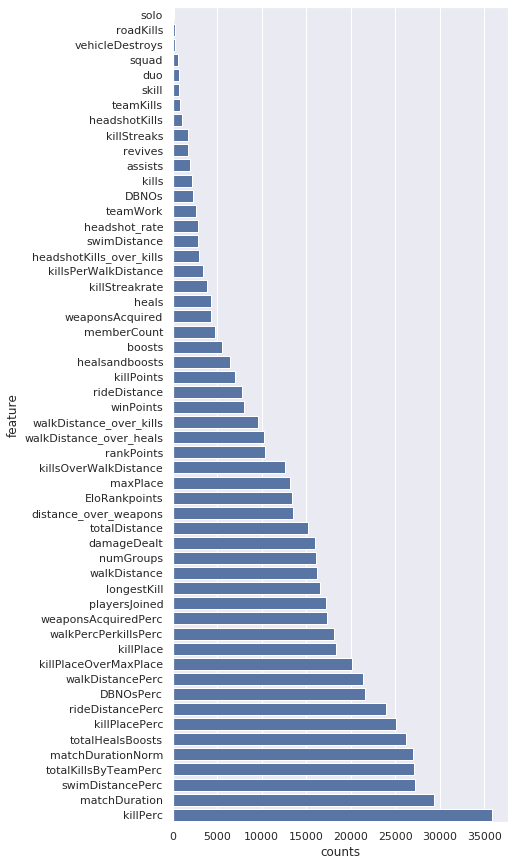

time: 998 ms


In [0]:
plot_feature(data)

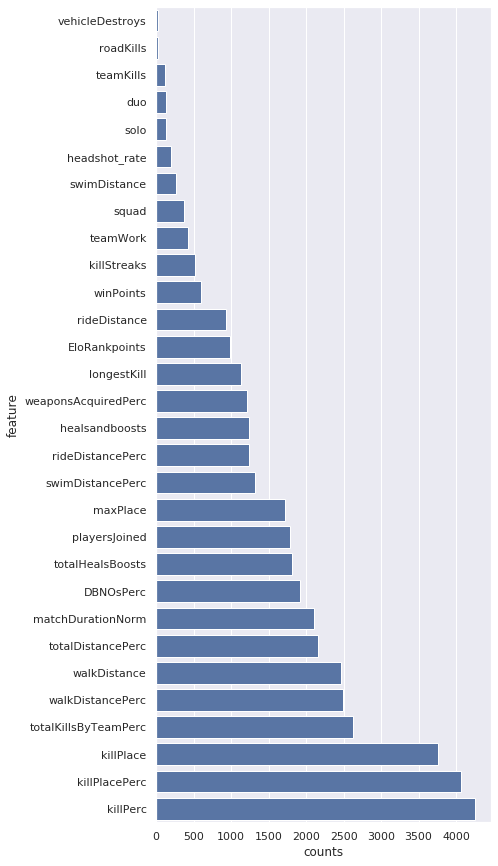

time: 575 ms


In [0]:
# plot_feature(data)

## HyperParam Tunning

In [0]:
import lightgbm as lgb
import numpy as np
from sklearn import pipeline
from hyperopt import hp
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial
from sklearn.metrics import mean_absolute_error as mae

time: 580 ms


In [0]:
# Define searched space for LightGBM
hyper_space = {'objective': 'regression',
               'metric':'mae',
               'boosting':'gbdt',
               #'n_estimators': hp.choice('n_estimators', [25, 40, 50, 75, 100, 250, 500]),
               'max_depth':  hp.choice('max_depth', [5, 8, 10, 12, 15]),
               'num_leaves': hp.choice('num_leaves', [100, 250, 500, 650, 750, 1000,1300]),
               'subsample': hp.choice('subsample', [.3, .5, .7, .8, 1]),
               'colsample_bytree': hp.choice('colsample_bytree', [ .6, .7, .8, .9, 1]),
               'learning_rate': hp.choice('learning_rate', [.1, .2, .3]),
               'reg_alpha': hp.choice('reg_alpha', [.1, .2, .3, .4, .5, .6]),
               'reg_lambda':  hp.choice('reg_lambda', [.1, .2, .3, .4, .5, .6]),
               'min_child_samples': hp.choice('min_child_samples', [20, 45, 70, 100]),
               'verbose': -1}

time: 7.53 ms


In [0]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_absolute_error as mae

# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: mae(y, pred)


time: 8.47 ms


In [0]:
import lightgbm as lgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

time: 13.4 ms


In [0]:
obj = HPOpt(X_train, X_test, y_train, y_test)

lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)



100%|██████████| 100/100 [51:03<00:00, 30.17s/it, best loss: 0.04656295533955639]
time: 51min 3s


In [0]:
lgb_opt

({'colsample_bytree': 4,
  'learning_rate': 5,
  'max_depth': 8,
  'min_child_weight': 2,
  'subsample': 0.9551099928910118},
 <hyperopt.base.Trials at 0x7f13a53a1b38>)

time: 2.57 ms


<p align="center" text-align="center">
  <img width='1000' height='550' src="https://drive.google.com/uc?id=1VMlR2CnMYcm9sZHEkNx4OWfPBvL9HKIh">
</p>